# Microcluster EDA & Theme Tagging Plan

This section outlines the workflow for evaluating microcluster quality and assigning consistent theme labels using LLM-assisted sampling.

---

## **1. Microcluster EDA**

### **Balance & Separation Checks**
- Inspect the size distribution of microclusters within each macro cluster.
- Verify whether microclusters are reasonably balanced or if some clusters dominate.
- Optionally visualise PCA or centroid distances to check separation quality.

---

## **2. Sampling Strategy**

### **Goal:**  
Collect a small, representative set of sample articles from each microcluster for theme inspection and LLM tagging.

### **Method:**  
For each `(macro_final, microcluster)` pair:
- Randomly sample **10 articles** using Spark's efficient `.sample()` method (avoids global shuffles).
- Capture `url` and `text` for documentation and clustering interpretability.

A simple helper function will handle cluster-level sampling:
- `sample_microcluster(df, macro_id, micro_id, n=10, frac=0.0005)`

---

## **3. LLM Tagging (Theme Assignment)**

For each microcluster:

1. Gather the sampled articles into a list.
2. Send them as a batch to an OpenAI model (e.g., `gpt-4o-mini`) with a concise theme-classification prompt.
3. Receive the **theme label** (e.g., *“Tech M&A”*, *“US Politics”*, *“Oil Markets”*).
4. Record:
   - macro cluster id  
   - microcluster id  
   - sample articles  
   - LLM-assigned theme  
   - timestamp, model info  

---

## **4. Repeated Runs for Stability**

To ensure reliable labels:

- Repeat the sampling + LLM tagging process **3 independent times**.
- Store the outputs in a Delta table with schema:

  | macro_final | microcluster | run_id | sample_id | url | text | llm_tag |
  |-------------|--------------|--------|-----------|-----|------|---------|

This lets us evaluate tag consistency across multiple random samples.

By analysing microcluster llm_tags across samples I will determine my final theme for the cluster which is vital for interpretation downstream

---

## **5. Final Outcome**

- A reproducible, LLM-assisted theme discovery workflow  
- Clean consensus topics for all microclusters  
- Full transparency via stored samples and multi-run stability analysis  
- Reliable, interpretable themes ready for time-series aggregation and modelling

---


In [7]:

from pathlib import Path
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip


#paths

NB_DIR = Path.cwd()                    
ROOT = NB_DIR.parent                    

print("Notebook directory:", NB_DIR)
print("Project root:", ROOT)

# Delta table paths
GOLD_DELTA = ROOT / "pipelines" / "gold" / "gold_delta"
CLUSTER_MICRO = ROOT / "clustering" / "microclusters_kmeans"

print("Gold Delta path:", GOLD_DELTA)
print("Macro Cluster Delta path:", CLUSTER_MICRO)

#spark
builder = (
    SparkSession.builder
        .appName("macro_eda")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        .config("spark.driver.memory", "8g")
        .config("spark.sql.shuffle.partitions", "16")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()
print("Spark session initialised.")


#load delta
df_gold = spark.read.format("delta").load(str(GOLD_DELTA))
df_micro = spark.read.format("delta").load(str(CLUSTER_MICRO))

#gold has legacy macro_cluster column my bad
if "macro_cluster" in df_gold.columns:
    df_gold = df_gold.drop("macro_cluster")
    print("Removed legacy macro_cluster column from gold table.")

df_join = df_gold.join(df_micro, on="url", how="inner")
df_join.show(5, truncate=False)
df_join.count() 


Notebook directory: /home/david/School/CapStone/clustering
Project root: /home/david/School/CapStone
Gold Delta path: /home/david/School/CapStone/pipelines/gold/gold_delta
Macro Cluster Delta path: /home/david/School/CapStone/clustering/microclusters_kmeans
Spark session initialised.
Removed legacy macro_cluster column from gold table.


+------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1949081

In [9]:
from pyspark.sql.functions import col

df_clusters = df_micro.select("url", "macro_final", "microcluster")

df_counts = (
    df_clusters
        .groupBy("macro_final", "microcluster")
        .count()
        .orderBy("macro_final", "microcluster")
)

df_counts.show(200, truncate=False)


+-----------+------------+-----+
|macro_final|microcluster|count|
+-----------+------------+-----+
|-1         |0           |47325|
|-1         |1           |93418|
|-1         |2           |76717|
|-1         |3           |89184|
|-1         |4           |83085|
|0          |0           |40857|
|0          |1           |50843|
|0          |2           |41807|
|0          |3           |50677|
|0          |4           |30011|
|1          |0           |9841 |
|1          |1           |32913|
|1          |2           |7040 |
|1          |3           |1635 |
|1          |4           |15869|
|2          |0           |18789|
|2          |1           |35326|
|2          |2           |18977|
|2          |3           |20647|
|2          |4           |28492|
|3          |0           |22091|
|3          |1           |48834|
|3          |2           |37724|
|3          |3           |40169|
|3          |4           |33061|
|4          |0           |17653|
|4          |1           |38602|
|4        

### manual inspect random samples for given macro and micro

In [ ]:
import pyspark.sql.functions as F

macro_id = 9
micro_id = 0         # ← choose one microcluster
N = 10                # ← number of samples

df_samples = (
    df_join
        .filter(
            (F.col("macro_final") == macro_id) &
            (F.col("microcluster") == micro_id)
        )
        .select("url", "macro_final", "microcluster")
        .orderBy(F.rand())        # local shuffle OK (small group)
        .limit(N)
)

df_samples.show(truncate=False)




+--------------------------------------------------------------------------------------------------------------------------------------------+-----------+------------+
|url                                                                                                                                         |macro_final|microcluster|
+--------------------------------------------------------------------------------------------------------------------------------------------+-----------+------------+
|https://www.cnbc.com/2017/04/27/uk-pm-may-has-weakened-her-brexit-hand-by-calling-snap-election-gina-miller.html                            |9          |0           |
|https://www.cnbc.com/2017/11/16/goldman-sachs-blankfein-just-called-for-a-second-brexit-referendum.html                                     |9          |0           |
|https://www.businessinsider.com/michael-gove-discussed-closing-banks-the-day-after-no-deal-brexit-2019-8                                    |9          |0     

# ssimple pipeline for sampling 50 micro clusters

In [2]:
import pyspark.sql.functions as F
#sample
#make sample LLM friendly
#build prompt
#send to OpenAI
#save results

def sample_one_micro(df, macro_id, micro_id, n=10):
    """
    Returns a Spark DF of n random articles from a given macro + micro cluster.
    Only url, text, macro_final, microcluster.
    """
    return (
        df.filter(
            (F.col("macro_final") == macro_id) &
            (F.col("microcluster") == micro_id)
        )
        .select("url", "text", "macro_final", "microcluster")
        .orderBy(F.rand())   # safe because microcluster is small
        .limit(n)
    )

def df_to_llm_samples(df_samples):
    pdf = df_samples.limit(10).toPandas()
    return [
        {
            "url": row["url"],
            "text": row["text"],
            "macro": int(row["macro_final"]),
            "micro": int(row["microcluster"]),
        }
        for _, row in pdf.iterrows()
    ]


def build_prompt(samples):
    """
    Prepare the LLM prompt for microcluster labeling.
    The model receives a clean list of (url, text).
    """
    return (
        "You are labeling a microcluster of news articles.\n"
        "Given the sample articles below, return a SHORT topic name "
        "that summarizes the shared theme.\n\n"
        f"{samples}\n\n"
        "Respond ONLY with the topic name."
    )

from pyspark.sql import Row

TAG_OUT = ROOT / "clustering" / "micro_tags"

# ensure table exists
(
    spark.createDataFrame([], "macro_final INT, microcluster INT, tag STRING")
         .write
         .format("delta")
         .mode("overwrite")
         .save(str(TAG_OUT))
)


def save_tag(macro_id, micro_id, tag):
    """
    Save a single tag (macro, micro, topic name) to a Delta table.
    """
    df = spark.createDataFrame(
        [Row(macro_final=int(macro_id), microcluster=int(micro_id), tag=str(tag))]
    )
    (
        df.write
          .format("delta")
          .mode("append")
          .save(str(TAG_OUT))
    )


In [3]:
#openai api interfacing


import os
from dotenv import load_dotenv
from pathlib import Path

#if for whaever reason you want to do this yourself
#make a .env and put in your openapi key there
#note for all the clusters this will put you back atleast 5 dollars depending on how complex of a model you use
#i mean realisitclaly i should have used the ufll text but also thats a lot of tokens and studnet budget and all yk yk


ROOT = Path.cwd().parent
dotenv_path = ROOT / ".env"
load_dotenv(dotenv_path=dotenv_path)

print("Loaded:", "OPENAI_API_KEY" in os.environ)

from openai import OpenAI
client = OpenAI()

#test
resp = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[{"role": "user", "content": "Hello"}]
)

print(resp.choices[0].message.content.strip())


def get_microcluster_tag(prompt, model="gpt-4.1-mini"):
    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You label microclusters."},
            {"role": "user", "content": prompt},
        ]
    )
    return resp.choices[0].message.content.strip()



Loaded: True
Hello! How can I assist you today?


In [4]:
def label_microcluster(df, macro_id, micro_id, n=10):
    # 1. Sample
    df_samples = sample_one_micro(df, macro_id, micro_id, n)

    # 2. Convert to LLM-ready Python objects
    samples_list = df_to_llm_samples(df_samples)

    # 3. Build prompt
    prompt = build_prompt(samples_list)

    # 4. Send to OpenAI
    tag = get_microcluster_tag(prompt)

    print(f"\nMicrocluster {micro_id} → '{tag}'")

    # 5. Save tag
    save_tag(macro_id, micro_id, tag)

    return tag, samples_list



### putting it all together
*make sure the openai connection is actuclaly there first btw and the df is loaded*

In [5]:
from pathlib import Path

OUT_CSV = Path("microcluster_tags.csv")

import csv
from datetime import datetime

#writing to csv cause its easier for small amounts of data and i can open in excel and stuff
def append_csv(macro_id, micro_id, tag, samples_list, out_path=OUT_CSV):
    urls  = [s["url"] for s in samples_list]
    texts = [s["text"] for s in samples_list]

    row = {
        "macro_final": macro_id,
        "microcluster": micro_id,
        "llm_tag": tag,
        "sample_urls": " || ".join(urls),
        "sample_texts": " || ".join(texts),
        "timestamp": datetime.utcnow().isoformat()
    }

    write_header = not out_path.exists()

    with open(out_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)
    print(f"Appended to {out_path}")

def label_microcluster(df, macro_id, micro_id, n=10):
    # 1. Sample
    df_samples = sample_one_micro(df, macro_id, micro_id, n)

    # 2. Convert to Python list
    samples_list = df_to_llm_samples(df_samples)

    # 3. Build prompt
    prompt = build_prompt(samples_list)

    # 4. Call the fixed OpenAI function
    tag = get_microcluster_tag(prompt)
    print(f"Macro {macro_id}, Micro {micro_id} → {tag}")

    # 5. Append to CSV
    append_csv(macro_id, micro_id, tag, samples_list)

    return tag



In [6]:
import pyspark.sql.functions as F
import time

def run_full_micro_tagging(df, n=10):
    """
    Loops through every macro cluster (0..9) and every microcluster inside it.
    For each (macro, micro) pair, samples articles, calls the LLM, and writes
    the result into microcluster_tags.csv.
    """

    # Get all existing (macro, micro) combos
    combos = (
        df.select("macro_final", "microcluster")
          .distinct()
          .orderBy("macro_final", "microcluster")
          .collect()
    )

    print(f"Found {len(combos)} macro/micro combinations to process.\n")

    for row in combos:
        macro_id = int(row["macro_final"])
        micro_id = int(row["microcluster"])

        # Only process macro clusters 0–9
        if macro_id < 0 or macro_id > 9:
            continue

        print(f"\n=== Processing Macro {macro_id} / Micro {micro_id} ===")

        # Sample this cluster
        df_samples = sample_one_micro(df, macro_id, micro_id, n)
        time.sleep(1) #cpu breathing time 

        # If empty → skip
        if df_samples.count() == 0:
            print("   (SKIP) No rows found in this microcluster.")
            continue

        # Convert to Python objects
        samples_list = df_to_llm_samples(df_samples)
      
        # Build the prompt
        prompt = build_prompt(samples_list)

        # Call OpenAI
        try:
            tag = get_microcluster_tag(prompt)
            print(f"   LLM Tag → {tag}")
        except Exception as e:
            print(f"   ERROR calling OpenAI: {e}")
            continue

        # Append to CSV
        append_csv(macro_id, micro_id, tag, samples_list)
        time.sleep(1) #cpu breathing time 

    print("\nAll macro/micro clusters processed!")

#5 samples of  10 cause SFE doenst come out till jan 9th </3
run_full_micro_tagging(df_join, n=10)


Found 55 macro/micro combinations to process.


=== Processing Macro 0 / Micro 0 ===


   LLM Tag → Business and Entertainment News Updates
Appended to microcluster_tags.csv

=== Processing Macro 0 / Micro 1 ===


   LLM Tag → Corporate Finance and Energy Sector Developments
Appended to microcluster_tags.csv

=== Processing Macro 0 / Micro 2 ===


   LLM Tag → Health and Technology Updates
Appended to microcluster_tags.csv

=== Processing Macro 0 / Micro 3 ===


   LLM Tag → Corporate Earnings Reports
Appended to microcluster_tags.csv

=== Processing Macro 0 / Micro 4 ===


   LLM Tag → Corporate Financial Updates
Appended to microcluster_tags.csv

=== Processing Macro 1 / Micro 0 ===


   LLM Tag → U.S. Political and Legal Controversies
Appended to microcluster_tags.csv

=== Processing Macro 1 / Micro 1 ===


   LLM Tag → US Politics and Social Movements
Appended to microcluster_tags.csv

=== Processing Macro 1 / Micro 2 ===


   LLM Tag → Health, Misinformation, and Policy Challenges
Appended to microcluster_tags.csv

=== Processing Macro 1 / Micro 3 ===


   LLM Tag → Political Campaigns and Impeachment Proceedings
Appended to microcluster_tags.csv

=== Processing Macro 1 / Micro 4 ===


   LLM Tag → US Politics and Policy Developments
Appended to microcluster_tags.csv

=== Processing Macro 2 / Micro 0 ===


   LLM Tag → Global financial markets and trade tensions
Appended to microcluster_tags.csv

=== Processing Macro 2 / Micro 1 ===


   LLM Tag → International Diplomacy and Security Developments
Appended to microcluster_tags.csv

=== Processing Macro 2 / Micro 2 ===


   LLM Tag → China Economic and Geopolitical Issues
Appended to microcluster_tags.csv

=== Processing Macro 2 / Micro 3 ===


   LLM Tag → US-China Trade and Supply Chain Impact
Appended to microcluster_tags.csv

=== Processing Macro 2 / Micro 4 ===


   LLM Tag → US Foreign Policy and International Relations under Trump
Appended to microcluster_tags.csv

=== Processing Macro 3 / Micro 0 ===


   LLM Tag → Biotech and Healthcare Business Developments
Appended to microcluster_tags.csv

=== Processing Macro 3 / Micro 1 ===


   LLM Tag → Corporate Leadership and Gender Diversity
Appended to microcluster_tags.csv

=== Processing Macro 3 / Micro 2 ===


   LLM Tag → Corporate Earnings and Financial Results
Appended to microcluster_tags.csv

=== Processing Macro 3 / Micro 3 ===


   LLM Tag → Global Economic and Financial Developments
Appended to microcluster_tags.csv

=== Processing Macro 3 / Micro 4 ===


   LLM Tag → Real Estate and Investment Updates
Appended to microcluster_tags.csv

=== Processing Macro 4 / Micro 0 ===


   LLM Tag → Brexit and UK Political Developments
Appended to microcluster_tags.csv

=== Processing Macro 4 / Micro 1 ===


   LLM Tag → Current Events and Political Issues
Appended to microcluster_tags.csv

=== Processing Macro 4 / Micro 2 ===


   LLM Tag → Global Health Crises and Humanitarian Issues
Appended to microcluster_tags.csv

=== Processing Macro 4 / Micro 3 ===


   LLM Tag → Global Economic and Political Developments
Appended to microcluster_tags.csv

=== Processing Macro 4 / Micro 4 ===


   LLM Tag → Global Crises and Security Incidents
Appended to microcluster_tags.csv

=== Processing Macro 5 / Micro 0 ===


   LLM Tag → Technology product launches and industry developments
Appended to microcluster_tags.csv

=== Processing Macro 5 / Micro 1 ===


   LLM Tag → Private Equity and Corporate Transactions
Appended to microcluster_tags.csv

=== Processing Macro 5 / Micro 2 ===


   LLM Tag → Corporate Mergers and Business Developments
Appended to microcluster_tags.csv

=== Processing Macro 5 / Micro 3 ===


   LLM Tag → Tech Industry Updates and Corporate Developments
Appended to microcluster_tags.csv

=== Processing Macro 5 / Micro 4 ===


   LLM Tag → Retail and Consumer Trends
Appended to microcluster_tags.csv

=== Processing Macro 6 / Micro 0 ===


   LLM Tag → Diverse Current and Historical News Stories
Appended to microcluster_tags.csv

=== Processing Macro 6 / Micro 1 ===


   LLM Tag → Donald Trump Political Controversies
Appended to microcluster_tags.csv

=== Processing Macro 6 / Micro 2 ===


   LLM Tag → Politics and Scandals
Appended to microcluster_tags.csv

=== Processing Macro 6 / Micro 3 ===


   LLM Tag → Trump 2020 Election and Controversies
Appended to microcluster_tags.csv

=== Processing Macro 6 / Micro 4 ===


   LLM Tag → US Political News
Appended to microcluster_tags.csv

=== Processing Macro 7 / Micro 0 ===


   LLM Tag → Political Scandals and Controversies
Appended to microcluster_tags.csv

=== Processing Macro 7 / Micro 1 ===


   LLM Tag → Political Corruption and Legal Investigations
Appended to microcluster_tags.csv

=== Processing Macro 7 / Micro 2 ===


   LLM Tag → Civil Rights and Justice Reform
Appended to microcluster_tags.csv

=== Processing Macro 7 / Micro 3 ===


   LLM Tag → Legal and human rights controversies
Appended to microcluster_tags.csv

=== Processing Macro 7 / Micro 4 ===


   LLM Tag → Political Controversies and Accountability
Appended to microcluster_tags.csv

=== Processing Macro 8 / Micro 0 ===


   LLM Tag → Mixed News Articles Cluster
Appended to microcluster_tags.csv

=== Processing Macro 8 / Micro 1 ===


   LLM Tag → News and Events Overview
Appended to microcluster_tags.csv

=== Processing Macro 8 / Micro 2 ===


   LLM Tag → Financial Markets and Economic Outlook
Appended to microcluster_tags.csv

=== Processing Macro 8 / Micro 3 ===


   LLM Tag → Economic Impacts and Trends
Appended to microcluster_tags.csv

=== Processing Macro 8 / Micro 4 ===


   LLM Tag → Diverse Professional Achievements and Insights
Appended to microcluster_tags.csv

=== Processing Macro 9 / Micro 0 ===


   LLM Tag → Brexit Developments and Impacts
Appended to microcluster_tags.csv

=== Processing Macro 9 / Micro 1 ===


   LLM Tag → Global Economic and Financial Market Updates
Appended to microcluster_tags.csv

=== Processing Macro 9 / Micro 2 ===


   LLM Tag → Oil Market Trends and Geopolitical Impact
Appended to microcluster_tags.csv

=== Processing Macro 9 / Micro 3 ===


   LLM Tag → Global Economic and Financial Market Developments
Appended to microcluster_tags.csv

=== Processing Macro 9 / Micro 4 ===


   LLM Tag → Global Stock Market Trends
Appended to microcluster_tags.csv

All macro/micro clusters processed!


## Consolidated Thematic Tags with Component Mappings

After generating 55 microcluster-level LLM tags from the two-stage clustering pipeline,  
we grouped semantically similar tags into consolidated themes.  
This improves interpretability and provides a stable taxonomy for downstream analysis.

Below is the final mapping of consolidated themes to their macro/micro components.

---

### 1. Corporate Earnings & Financial Performance
- Macro 0 / Micro 3 (Corporate Earnings Reports)  
- Macro 0 / Micro 4 (Corporate Financial Updates)  
- Macro 3 / Micro 2 (Corporate Earnings and Financial Results)

### 2. Financial Markets & Trading
- Macro 8 / Micro 2 (Financial Markets and Economic Outlook)  
- Macro 9 / Micro 1 (Global Economic and Financial Market Updates)  
- Macro 9 / Micro 3 (Global Economic and Financial Market Developments)  
- Macro 9 / Micro 4 (Global Stock Market Trends)

### 3. Macroeconomic Trends & Outlook
- Macro 8 / Micro 3 (Economic Impacts and Trends)  
- Macro 3 / Micro 3 (Global Economic and Financial Developments)  
- Macro 4 / Micro 3 (Global Economic and Political Developments)

### 4. Energy & Commodities Markets
- Macro 0 / Micro 1 (Corporate Finance and Energy Sector Developments)  
- Macro 9 / Micro 2 (Oil Market Trends and Geopolitical Impact)

### 5. Corporate M&A & Private Equity
- Macro 5 / Micro 1 (Private Equity and Corporate Transactions)  
- Macro 5 / Micro 2 (Corporate Mergers and Business Developments)

### 6. Biotech & Healthcare Business
- Macro 3 / Micro 0 (Biotech and Healthcare Business Developments)

### 7. Tech Industry & Innovation
- Macro 0 / Micro 2 (Health and Technology Updates)  
- Macro 5 / Micro 0 (Technology product launches and industry developments)  
- Macro 5 / Micro 3 (Tech Industry Updates and Corporate Developments)

### 8. Retail, Real Estate & Consumer
- Macro 3 / Micro 1 (Corporate Leadership and Gender Diversity)  
- Macro 3 / Micro 4 (Real Estate and Investment Updates)  
- Macro 5 / Micro 4 (Retail and Consumer Trends)

### 9. US Domestic Politics
- Macro 1 / Micro 1 (US Politics and Social Movements)  
- Macro 1 / Micro 3 (Political Campaigns and Impeachment Proceedings)  
- Macro 1 / Micro 4 (US Politics and Policy Developments)  
- Macro 6 / Micro 4 (US Political News)

### 10. Political Scandals & Legal Issues
- Macro 1 / Micro 0 (U.S. Political and Legal Controversies)  
- Macro 6 / Micro 1 (Donald Trump Political Controversies)  
- Macro 6 / Micro 2 (Politics and Scandals)  
- Macro 6 / Micro 3 (Trump 2020 Election and Controversies)  
- Macro 7 / Micro 0 (Political Scandals and Controversies)  
- Macro 7 / Micro 1 (Political Corruption and Legal Investigations)  
- Macro 7 / Micro 4 (Political Controversies and Accountability)

### 11. International Trade & Relations
- Macro 2 / Micro 0 (Global financial markets and trade tensions)  
- Macro 2 / Micro 3 (US-China Trade and Supply Chain Impact)  
- Macro 2 / Micro 4 (US Foreign Policy and International Relations under Trump)

### 12. Global Geopolitics & Security
- Macro 2 / Micro 1 (International Diplomacy and Security Developments)  
- Macro 2 / Micro 2 (China Economic and Geopolitical Issues)  
- Macro 4 / Micro 4 (Global Crises and Security Incidents)

### 13. UK & Brexit
- Macro 4 / Micro 0 (Brexit and UK Political Developments)  
- Macro 9 / Micro 0 (Brexit Developments and Impacts)

### 14. Health Policy & Public Health Crises
- Macro 1 / Micro 2 (Health, Misinformation, and Policy Challenges)  
- Macro 4 / Micro 2 (Global Health Crises and Humanitarian Issues)

### 15. Civil Rights & Justice Reform
- Macro 7 / Micro 2 (Civil Rights and Justice Reform)  
- Macro 7 / Micro 3 (Legal and human rights controversies)

### 16. General / Mixed News
- Macro 0 / Micro 0 (Business and Entertainment News Updates)  
- Macro 4 / Micro 1 (Current Events and Political Issues)  
- Macro 6 / Micro 0 (Diverse Current and Historical News Stories)  
- Macro 8 / Micro 0 (Mixed News Articles Cluster)  
- Macro 8 / Micro 1 (News and Events Overview)  
- Macro 8 / Micro 4 (Diverse Professional Achievements and Insights)

---

This taxonomy will be used for theme-level aggregation, merging article features with financial data, and running lead–lag or predictive modelling across unified topic categories.


In [10]:
#following this tagging i merged clusters in the main clustering notebook
#now im gonna look at the clusters and visualise them mostly for a fun final touch

from pathlib import Path
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip


# Paths
NB_DIR = Path.cwd()
ROOT = NB_DIR.parent

GOLD_DELTA = ROOT / "pipelines" / "gold" / "gold_delta"
THEMATIC_DELTA = ROOT / "clustering" / "thematic_clusters"   
print("Thematic Cluster Delta:", THEMATIC_DELTA)


# Spark session
builder = (
    SparkSession.builder
        .appName("umap_thematic")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        .config("spark.driver.memory", "10g")
        .config("spark.sql.shuffle.partitions", "16")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()
print("Spark ready.")


# Load data
df_gold = spark.read.format("delta").load(str(GOLD_DELTA))
df_theme = spark.read.format("delta").load(str(THEMATIC_DELTA))

# Remove old macro column if present
if "macro_cluster" in df_gold.columns:
    df_gold = df_gold.drop("macro_cluster")

# Join on URL
df = df_gold.join(df_theme, on="url", how="inner")
df.show(5, truncate=False)
print("Joined rows:", df.count())


Thematic Cluster Delta: /home/david/School/CapStone/clustering/thematic_clusters
Spark ready.


25/12/07 22:19:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Joined rows: 1949081


/home/david/School/CapStone/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/david/School/CapStone/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


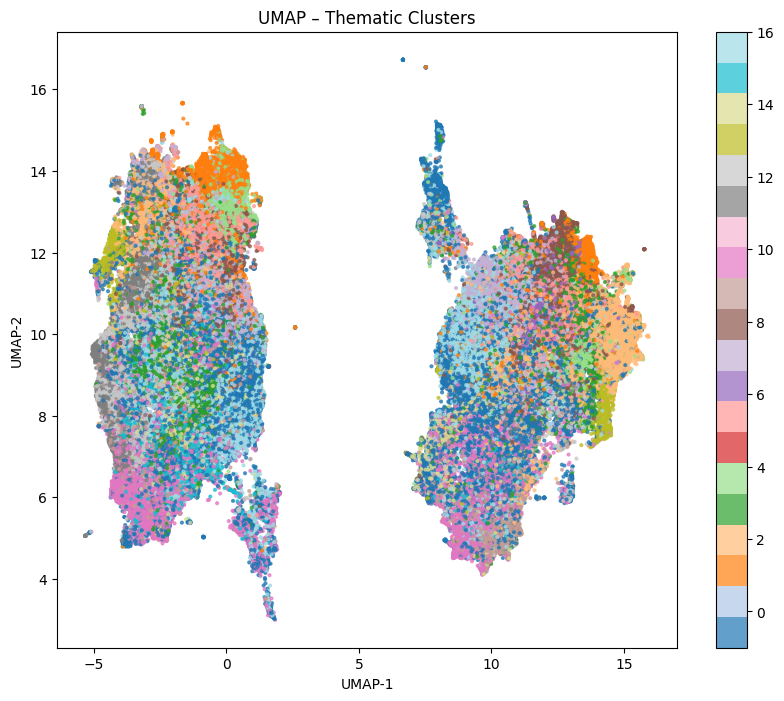

25/12/08 09:48:25 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 38705598 ms exceeds timeout 120000 ms
25/12/08 09:48:25 WARN SparkContext: Killing executors is not supported by current scheduler.
25/12/08 09:48:25 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at

In [12]:
#PCA columns
pca_cols = [c for c in df.columns if c.startswith("pca_")]

cluster_col = "thematic_cluster"  # <-- change if named differently

df_small = df.select(pca_cols + [cluster_col])

pdf = (
    df_small
        .sampleBy(cluster_col, fractions={c: 0.15 for c in df_small.select(cluster_col).distinct().toPandas()[cluster_col]}, seed=42)
        .toPandas()
)

import umap
import numpy as np

X = pdf[pca_cols].values
y = pdf[cluster_col].values

um = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding = um.fit_transform(X)
pdf["umap_x"] = embedding[:, 0]
pdf["umap_y"] = embedding[:, 1]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pdf["umap_x"],
    pdf["umap_y"],
    c=pdf[cluster_col],
    s=4,
    alpha=0.7,
    cmap="tab20"
)

plt.title("UMAP – Thematic Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter)
plt.show()
